In [2]:
import os, xarray as xr, numpy as np
import matplotlib.pyplot as plt

#import glob
#import utmToLatLng as utm
import pandas as pd
#import zarr
import math
from datetime import timedelta
from operator import attrgetter
import trajan as ta
from IPython.display import HTML
#from matplotlib.animation import FuncAnimation

from parcels import (
    AdvectionRK4,
    FieldSet,
    ScipyParticle, #this is slow but should be fine for just one particle
    JITParticle, #this will process faster
    ParticleSet,
    Variable,
    download_example_dataset,
)


In [3]:

my_decomposition = 'HelmholtzKernel'

result_dir = f'./results/{my_decomposition}'

nc_dir = os.path.join(result_dir, 'netcdf')

parcels_dir = os.path.join(result_dir, 'parcels')
if not os.path.exists(parcels_dir):
    os.makedirs(parcels_dir)


In [6]:
nc_file

'./results/HelmholtzKernel/netcdf/Krigging_output_2014_08_02_10.nc'

In [15]:

scene = 10
file_stub = f'Krigging_output_2014_08_02_{scene}'

parcels_subdir = os.path.join(parcels_dir, file_stub)
if not os.path.exists(parcels_subdir):
    os.makedirs(parcels_subdir)

nc_file = os.path.join(nc_dir, file_stub+'.nc')

ds = xr.open_dataset(nc_file)
ds

/home/andrew/anaconda3/envs/surfacecurrents/lib/python3.12/site-packages/xarray/namedarray/core.py:514: UserWarning: Duplicate dimension names present: dimensions {'2s'} appear more than once in dims=('t', '2s', '2s'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.warn(


<xarray.Dataset> Size: 63MB
Dimensions:    (t: 1, s: 1404, 2s: 2808)
Coordinates:
    Lat_model  (t, s) float64 11kB ...
    Lon_model  (t, s) float64 11kB ...
    X_model    (t, s) float64 11kB ...
    Y_model    (t, s) float64 11kB ...
    scene      (t) int64 8B ...
Dimensions without coordinates: t, s, 2s
Data variables:
    mean_u     (t, s) float64 11kB ...
    mean_v     (t, s) float64 11kB ...
    K_pp       (t, 2s, 2s) float64 63MB ...
Attributes:
    date:              2014_08_02
    scene:             10
    scenetime:         0500
    my_decomposition:  HelmholtzKernel
    kernel_fcn:        square-exp
    radial_sdev:       10
    L:                 4400
    nugget_sdev:       1.0
    grid_size:         [39 36]

[39 36]


/home/andrew/anaconda3/envs/surfacecurrents/lib/python3.12/site-packages/xarray/namedarray/core.py:514: UserWarning: Duplicate dimension names present: dimensions {'2s'} appear more than once in dims=('2s', '2s'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.warn(


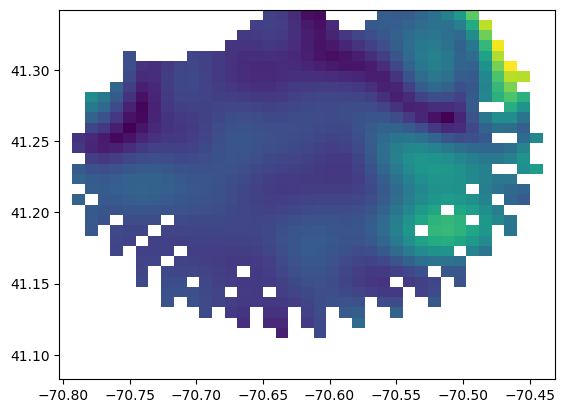

In [8]:

if True:
    grid_size = ds.attrs['grid_size']
    print(grid_size)

    t = 0
    if False: # don't think this works
        E_model = ds.X_model[t, :].values.reshape(grid_size)
        N_model = ds.Y_model[t, :].values.reshape(grid_size)
        mesh = 'flat'

        sx = 377031.17591511
        sy = 4569903.36639979

        
        qscale = 2000/110000
    else:
        E_model = ds.Lon_model[t, :].values.reshape(grid_size)
        N_model = ds.Lat_model[t, :].values.reshape(grid_size)
        mesh = 'spherical'

        sx = -70.47
        sy = 41.28

        qscale = 2000

    mean_u = ds.mean_u.values.reshape(grid_size)
    mean_v = ds.mean_v.values.reshape(grid_size)

    mean_s = np.abs(mean_u + 1.0j*mean_v)
    plt.pcolormesh(E_model, N_model, mean_s)

    blank = np.isnan(mean_u) 
    mean_u[blank] = 0
    mean_v[blank] = 0

    


else:

    dx = 800
    dy = 800
    
    Nx = 40
    Ny = 40
    # Input data points
    xd = np.arange(0,dx*Nx,dx)[:,None]#-dx/2
    yd = np.arange(0,dy*Ny,dy)[:,None]#-dy/2

    # Make a grid
    E_model, N_model = np.meshgrid(xd, yd)

    mean_u = np.zeros_like(E_model) - 100
    mean_v = np.zeros_like(E_model) - 100

    sx, sy = 30000, 30000

    qscale = 2000/11000


K_pp = ds.K_pp[t, :, :].values


In [9]:
# G = E_model.flatten()
# ind = np.where(abs(G-377000)==min(abs(G-377000)))
# print(G[ind])

# G = N_model.flatten()
# ind = np.where(abs(G-4570000)==min(abs(G-4570000)))
# print(G[ind])

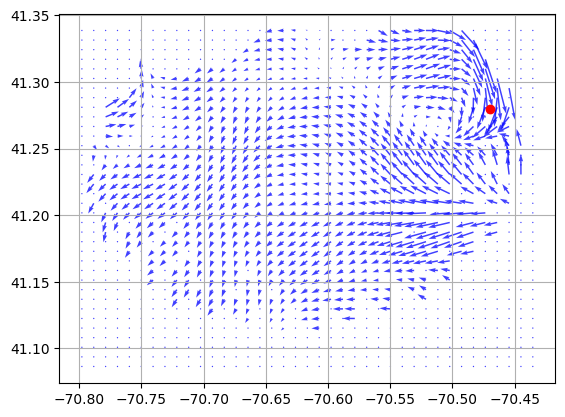

In [10]:

plt.quiver(E_model, N_model, mean_u, mean_v, color='b', alpha=0.75, scale_units='xy', scale=qscale, width=0.003)
plt.plot(sx, sy, 'ro')
plt.grid()
plt.show()



In [11]:
mesh

'spherical'

In [13]:
import afloat.time as ztime

nt = 2

def do_parcels(filename, nt, U, V):
    time = np.arange(0, nt)*3600*24
    time = ztime.datetime64_from_seconds_since(time)

    # Currents are in cm/s but we can scale as we please - effectivelt we're scaling time
    U, V = U/100, V/100 # M/S
    # U, V = U/10, V/10 # DM/S
    # U, V = U/1, V/1 # CM/S

    data = {
            "U": U,
            "V": V
        }

    dimensions = {"lon": E_model.T, "lat": N_model.T, "time": time} # Use flat to get 

    fieldset = FieldSet.from_data(data, dimensions, allow_time_extrapolation = True, mesh=mesh)

    pset = ParticleSet.from_list(
            fieldset=fieldset,
            pclass=JITParticle,
            lon = sx,
            lat = sy,
            #repeatdt = timedelta(hours=1) this releases the same lot of particles every timestep
        )

    step = 15
    output_file = pset.ParticleFile(
            name=filename,  # the file name
            outputdt=timedelta(minutes=step),  # the time step of the outputs
        )

    pset.execute(
            AdvectionRK4,  # the kernel (which defines how particles move)
            runtime=timedelta(minutes=24*60),  # the total length of the run
            dt=timedelta(minutes=step),  # the timestep of the kernel
            output_file=output_file,
            #recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle} this removes a particle if it goes outside your grid
        )
    


# Do a mean

In [16]:
filename = os.path.join(parcels_subdir, 'parcels_mean.zarr')

U = mean_u.T[None, :, :][np.zeros(nt).astype(int), :, :]
V = mean_v.T[None, :, :][np.zeros(nt).astype(int), :, :]

do_parcels(filename, nt, U, V)


INFO: Output files are stored in ./results/HelmholtzKernel/parcels/Krigging_output_2014_08_02_10/parcels_mean.zarr.
100%|██████████| 86400.0/86400.0 [02:05<00:00, 686.36it/s]


# Conditional now

In [17]:
from scipy import linalg as la

mean = np.hstack([mean_u.ravel(), mean_v.ravel()])[:, None]
samples = 1
myrand = np.random.normal(size=(len(mean), samples))
K_pp_ = K_pp + 1e-7*np.eye(K_pp.shape[0])
L_chol = la.cholesky(K_pp_, lower=True)

for iter in np.arange(0, 100):

    cond = mean + L_chol.dot(myrand)

    cond_u = cond[0:len(cond)//2]
    cond_v = cond[len(cond)//2::]

    U = cond_u.reshape(grid_size).T[None, :, :][np.zeros(nt).astype(int), :, :]
    V = cond_v.reshape(grid_size).T[None, :, :][np.zeros(nt).astype(int), :, :]

    filename = os.path.join(parcels_dir, file_stub+f'_parcels_cond_{iter}.zarr')
    do_parcels(filename, nt, U, V)



INFO: Output files are stored in ./results/HelmholtzKernel/parcels/Krigging_output_2014_08_02_10_parcels_cond_0.zarr.
100%|██████████| 86400.0/86400.0 [01:40<00:00, 858.75it/s]
INFO: Output files are stored in ./results/HelmholtzKernel/parcels/Krigging_output_2014_08_02_10_parcels_cond_1.zarr.
100%|██████████| 86400.0/86400.0 [01:45<00:00, 820.49it/s]
INFO: Output files are stored in ./results/HelmholtzKernel/parcels/Krigging_output_2014_08_02_10_parcels_cond_2.zarr.
100%|██████████| 86400.0/86400.0 [01:50<00:00, 780.40it/s]
INFO: Output files are stored in ./results/HelmholtzKernel/parcels/Krigging_output_2014_08_02_10_parcels_cond_3.zarr.
100%|██████████| 86400.0/86400.0 [01:55<00:00, 749.00it/s]
INFO: Output files are stored in ./results/HelmholtzKernel/parcels/Krigging_output_2014_08_02_10_parcels_cond_4.zarr.
100%|██████████| 86400.0/86400.0 [01:52<00:00, 768.45it/s]
INFO: Output files are stored in ./results/HelmholtzKernel/parcels/Krigging_output_2014_08_02_10_parcels_cond_5.zar

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


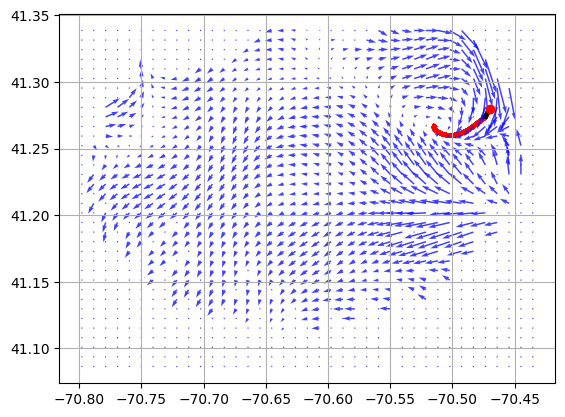

In [19]:

plt.quiver(E_model, N_model, mean_u, mean_v, color='b', alpha=0.75, scale_units='xy', scale=qscale, width=0.003)
plt.plot(sx, sy, 'ro')
plt.grid()

for iter in np.arange(0, 100):
    print(iter)
    # filename = os.path.join(parcels_dir, f'COND_{iter}.zarr')
    filename = os.path.join(parcels_dir, file_stub+f'_parcels_cond_{iter}.zarr')

    if os.path.exists(filename):
        ds_real  = xr.open_zarr(filename)
        plt.plot(ds_real.lon.values[0, 0::],  ds_real.lat.values[0, 0::],  'r', lw=3,  label='Conditional trajectory', zorder=-2000)


# filename = os.path.join(parcels_dir, 'MEAN.zarr')
filename = os.path.join(parcels_subdir, 'parcels_mean.zarr')
ds_real  = xr.open_zarr(filename)
plt.plot(ds_real.lon.values[0, 0::],  ds_real.lat.values[0, 0::],  'k', lw=3,  label='Mean trajectory', zorder=-1000)

plt.show()


In [21]:
ds_real

ImportError: Dask diagnostics requirements are not installed.

Please either conda or pip install as follows:

  conda install dask                     # either conda install
  python -m pip install "dask[diagnostics]" --upgrade  # or python -m pip install

<xarray.Dataset> Size: 2kB
Dimensions:     (trajectory: 1, obs: 96)
Coordinates:
  * obs         (obs) int32 384B 0 1 2 3 4 5 6 7 8 ... 88 89 90 91 92 93 94 95
  * trajectory  (trajectory) int64 8B 1
Data variables:
    lat         (trajectory, obs) float32 384B dask.array<chunksize=(1, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 384B dask.array<chunksize=(1, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 768B dask.array<chunksize=(1, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 384B dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        3.0.6

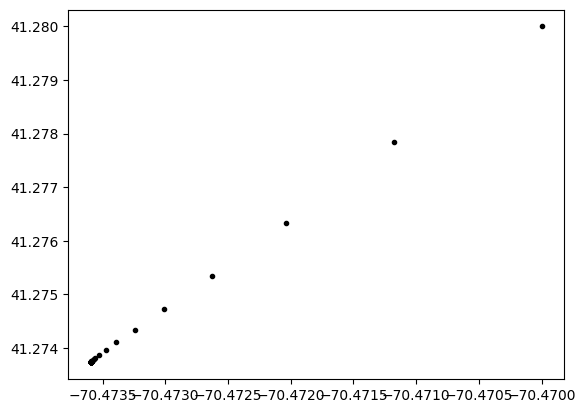

In [22]:
plt.plot(ds_real.lon.values[0, 0::],  ds_real.lat.values[0, 0::],  'k.', lw=3,  label='Mean trajectory', zorder=-1000)


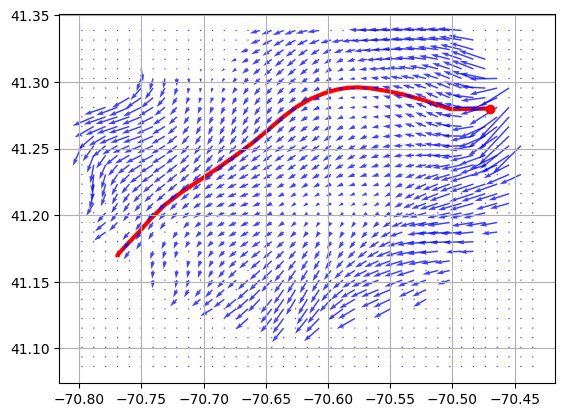

In [173]:
ds_real  = xr.open_zarr(filename)

plt.quiver(E_model, N_model, mean_u, mean_v, color='b', alpha=0.75, scale_units='xy', scale=qscale, width=0.003)
plt.plot(sx, sy, 'ro')
plt.grid()


plt.plot(ds_real.lon.values[0, 0::],  ds_real.lat.values[0, 0::],  'r', lw=3,  label='Real trajectory', zorder=-2000)

plt.show()



In [144]:
4 # metres per secon

# Metres in 15 minutes
print(1 * 15 * 60)
# Metres in 15 hours
print(1 * 15 * 60 * 60)

900
54000


# For Adele, ignore

In [2]:
L = 10000

x = np.arange(1, 10000)

NameError: name 'np' is not defined